# Simulations light inter

In [1]:
from __future__ import annotations

import math
import os
import sys
import time as t
from datetime import date
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append("../data") 
from archi_dict import archi_sorghum_angles as archi
from oawidgets.plantgl import *  # noqa: F403

from openalea.archicrop.display import build_scene, display_scene  # noqa: F401
from openalea.archicrop.simulation import (
    compute_extinction_coef,
    plot_constained_vs_pot,
    plot_constrainted_vs_realized,
    plot_extinction_coef,
    plot_faPAR,
    plot_PAR,
    run_simulations,
    write_netcdf,
)
from openalea.plantgl.all import Color3, Material, Scene  # noqa: F401

%gui qt

In [2]:
stics_color = "orange"
archicrop_color = "green"

In [34]:
tec_file_xml='../data/02NT18SorgV2D1_tec.xml'
plt_file_xml='../data/sorgho_imp_M_v10_plt.xml'
stics_output_file='../data/mod_s02NT18SorgV2D1.sti'
weather_file = '../data/ntarla_corr.2018'
location = {  
'longitude': 3.87,
'latitude': 12.58,
'altitude': 800,
'timezone': 'Europe/Paris'}

In [35]:
seed = 18

In [36]:
day_str = "2025-09-16"
ds = xr.open_dataset(f"D:/PhD_Oriane/simulations_ArchiCrop/{day_str}/results_light_inter_{seed}.nc")
ds

<xarray.Dataset> Size: 24MB
Dimensions:                 (time: 120, id: 27)
Coordinates:
  * id                      (id) int32 108B 0 1 2 3 4 5 6 ... 21 22 23 24 25 26
  * time                    (time) datetime64[ns] 960B 2018-06-30 ... 2018-10-27
Data variables: (12/43)
    thermal_time            (time) float64 960B ...
    lai_stics               (time) float64 960B ...
    sen_lai_stics           (time) float64 960B ...
    height_stics            (time) float64 960B ...
    inc_par                 (time) float64 960B ...
    abs_par_stics           (time) float64 960B ...
    ...                      ...
    insertion_angle         (id) float64 216B ...
    curvature               (id) float64 216B ...
    phyllotactic_angle      (id) float64 216B ...
    filter_1                (id) bool 27B ...
    filter_2                (id) float64 216B ...
    filter_3                (id) float64 216B ...

In [37]:
dates = ds.time.values
dates = pd.to_datetime(dates)
dates = dates.strftime('%Y-%m-%d')
thermal_time = ds.thermal_time.values
leaf_area_plant = ds.lai_stics.values
sen_leaf_area_plant = ds.sen_lai_stics.values
height_canopy = ds.height_stics.values
par_incident = ds.inc_par.values
par_stics = ds.abs_par_stics.values
sowing_density = float(ds.sowing_density.values)

phyllotactic_angle = ds.phyllotactic_angle.values
insertion_angle = ds.insertion_angle.values
curvature = ds.curvature.values
scurv = ds.scurv.values

pot_la = dict(zip(ds.id.values, ds.pot_la.values))
pot_h = dict(zip(ds.id.values, ds.pot_h.values))
realized_la = dict(zip(ds.id.values, ds.realized_la.values))
realized_h = dict(zip(ds.id.values, ds.realized_h.values))
nrj_per_plant = dict(zip(ds.id.values, ds.nrj_per_plant.values))

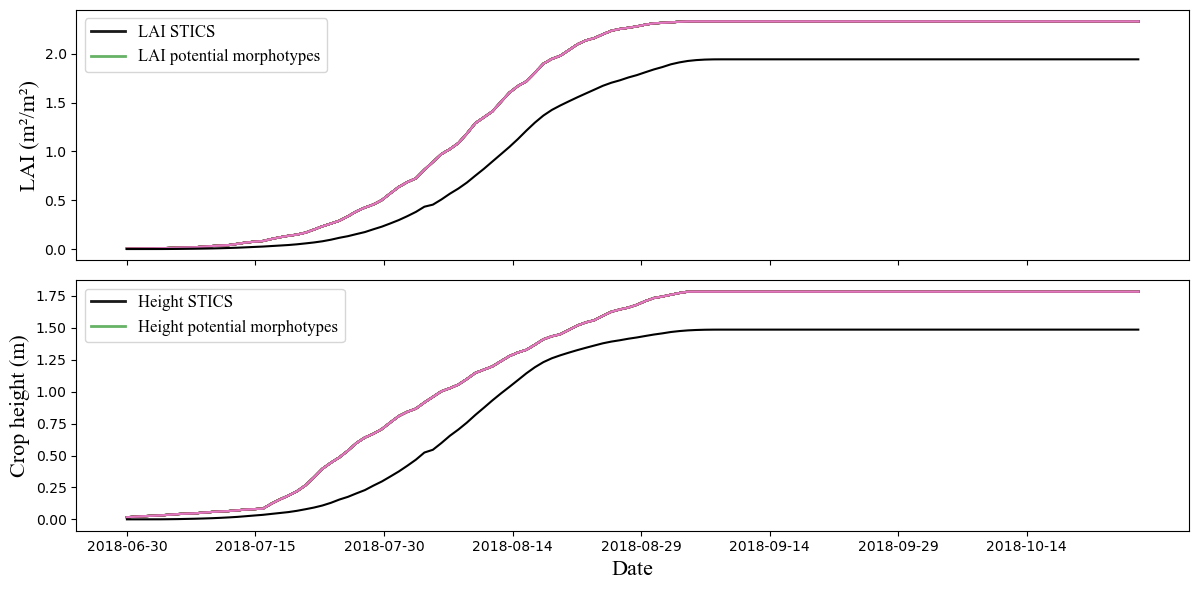

In [38]:
plot_constained_vs_pot(dates, pot_la, pot_h, leaf_area_plant, height_canopy, sowing_density, stics_color="black")

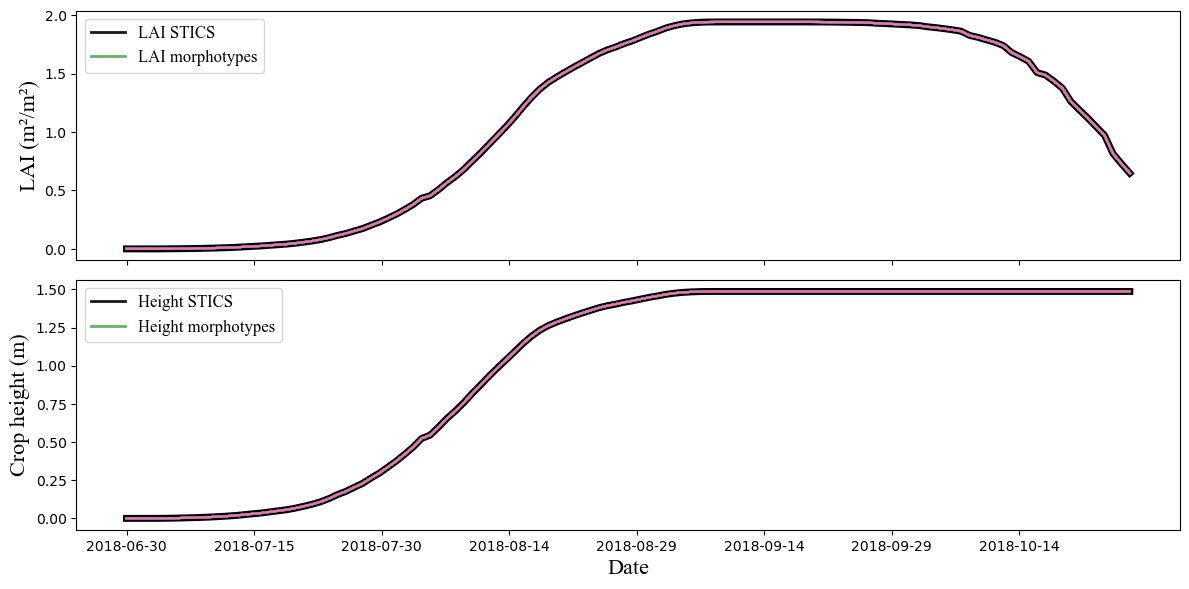

In [39]:
plot_constrainted_vs_realized(dates=dates, 
                              LA_archicrop=realized_la, 
                              height_archicrop=realized_h, 
                              leaf_area_plant=leaf_area_plant, 
                              sen_leaf_area_plant=sen_leaf_area_plant, 
                              height_canopy=height_canopy, 
                              sowing_density=sowing_density,
                              stics_color="black")


In [40]:
# Energy in Caribu : MJ.day-1
# Irradiance in Caribu : MJ.m[leaf]-2.day-1
# Incident PAR in STICS : MJ.m[soil]-2.day-1
# Absorbed PAR in STICS : MJ.m[soil]-2.day-1

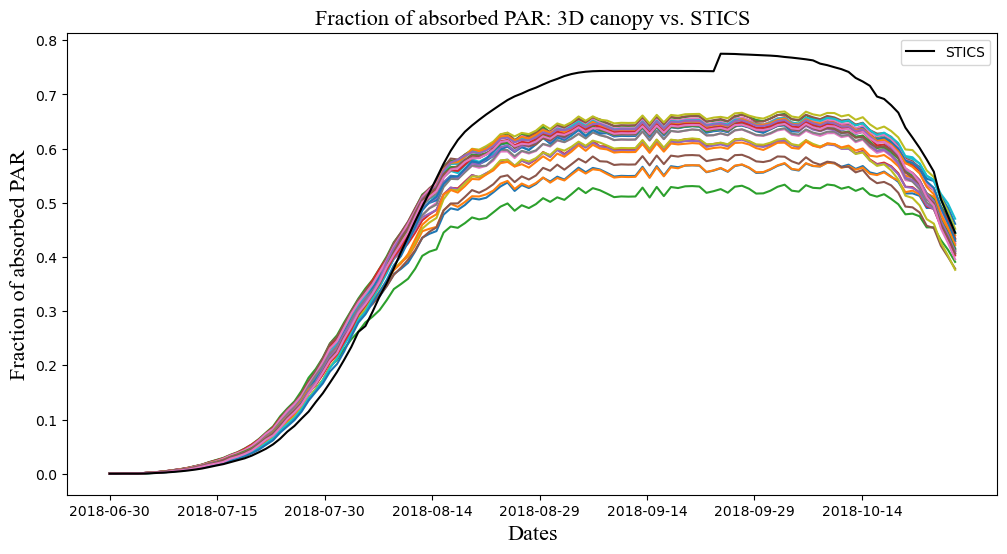

In [41]:
if nrj_per_plant[0][0] is not None:
    plot_faPAR(dates, nrj_per_plant, par_incident, par_stics, sowing_density, stics_color="black")

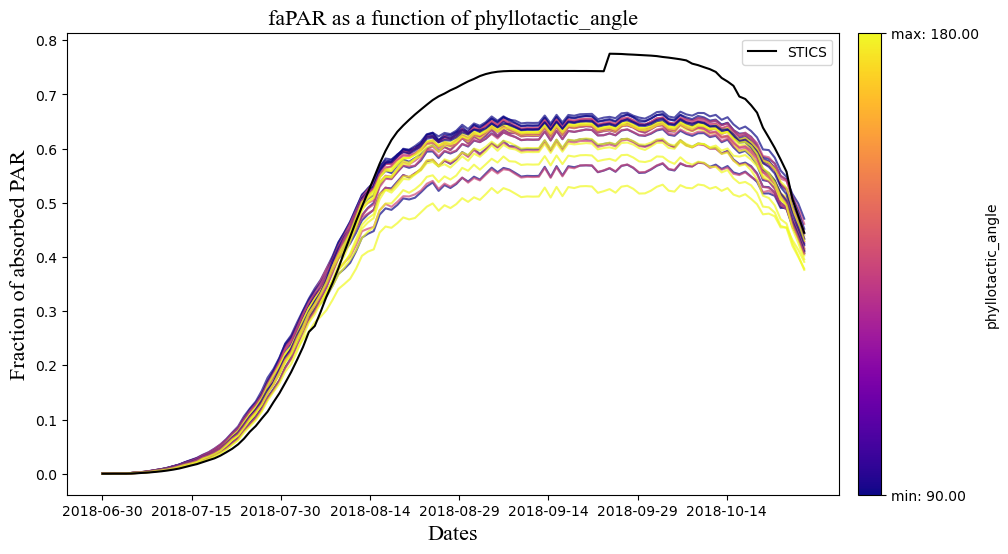

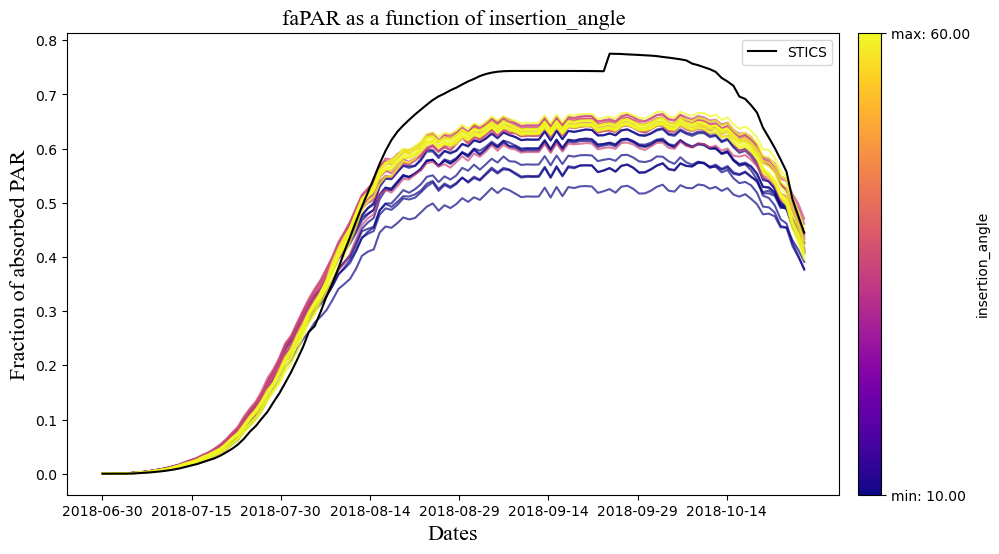

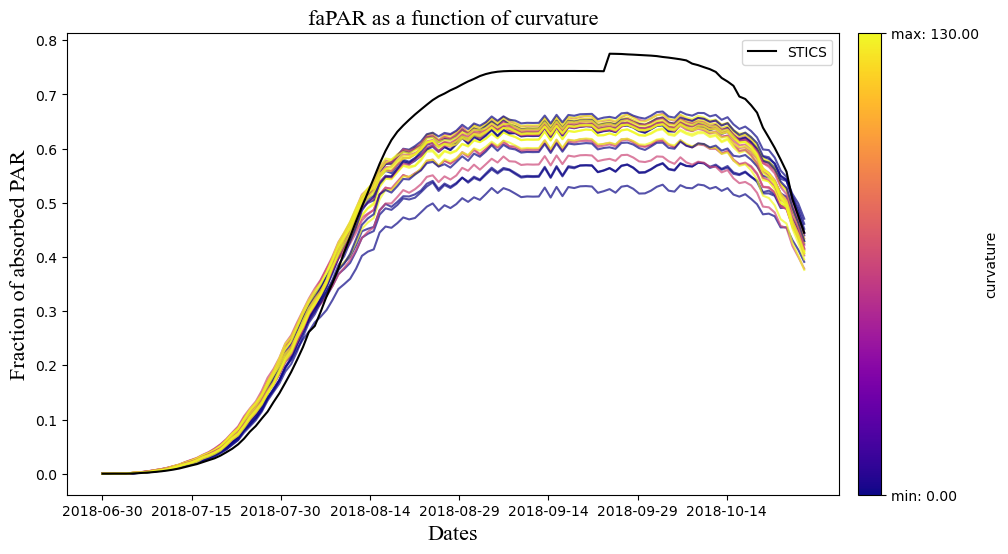

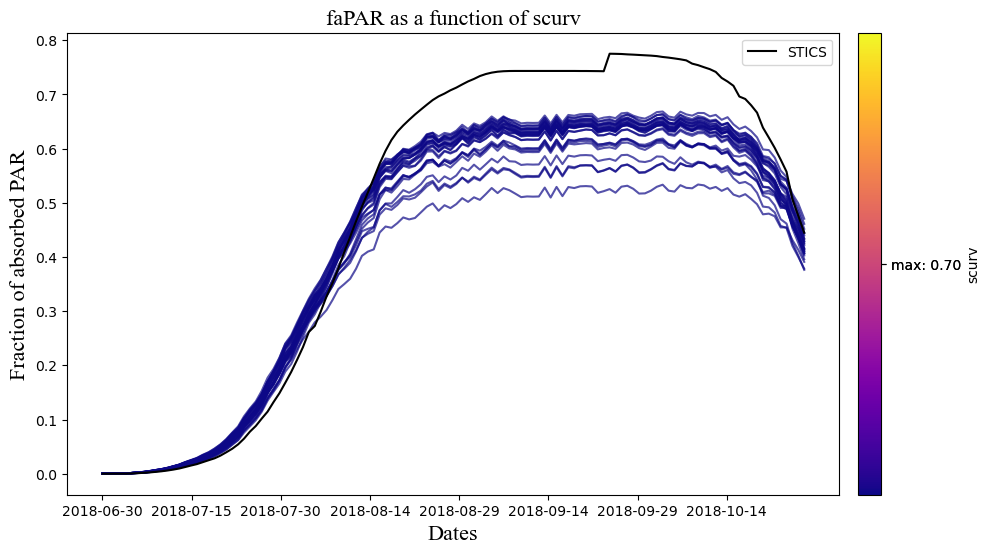

In [47]:
def plot_faPAR_parameter(dates, nrj_per_plant, par_incident, par_stics, sowing_density, archi, parameter, parameter_name, archicrop_color, stics_color):
    fig, ax = plt.subplots(figsize=(12, 6))
    # for k,curve in nrj_per_plant.items():
    #     # ax.plot(dates, [nrj*sowing_density/par for nrj,par in zip(curve, par_incident)]) #, color=archicrop_color, alpha=0.4, label="ArchiCrop x Caribu")
    #     label = f"{parameter_name}={parameter[k]:.2f}" if parameter[k] == min(parameter) or parameter[k] == max(parameter) else None
    #     alpha = (parameter[k]-min(archi[parameter_name]))/(max(parameter)-min(archi[parameter_name]))
    #     ax.plot(dates, [nrj/par for nrj,par in zip(curve, par_incident)], color=archicrop_color, alpha=alpha, label=label) #, label=f"{parameter[k]}") #, color=archicrop_color, alpha=0.4, label="ArchiCrop x Caribu")

    # Normalize parameter values to [0, 1] for colormap
    param_values = np.array([parameter[k] for k in nrj_per_plant])
    norm = plt.Normalize(param_values.min(), param_values.max())
    cmap = plt.get_cmap('plasma')  # You can choose any matplotlib colormap

    for k, curve in nrj_per_plant.items():
        color = cmap(norm(parameter[k]))
        label = f"{parameter_name}={parameter[k]:.2f}" if parameter[k] == param_values.min() or parameter[k] == param_values.max() else None
        ax.plot(dates, [nrj/par for nrj, par in zip(curve, par_incident)], color=color, alpha=0.7) #, label=label)


    # ax.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
    # ax.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
    # ax.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
    ax.plot(dates, par_stics, color=stics_color, label="STICS")

    # Labels and legend
    ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
    ax.set_xlabel("Dates", fontsize=16, fontname="Times New Roman") 
    ax.set_ylabel("Fraction of absorbed PAR", fontsize=16, fontname="Times New Roman")
    ax.set_title(f"faPAR as a function of {parameter_name}", fontsize=16, fontname="Times New Roman")

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(f"{parameter_name}")
    cbar.set_ticks([param_values.min(), param_values.max()])
    cbar.set_ticklabels([f"min: {param_values.min():.2f}", f"max: {param_values.max():.2f}"])


    ax.legend()

    # Save figure
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_faPAR_{parameter_name}.png")

    plt.show()

plot_faPAR_parameter(dates, nrj_per_plant, par_incident, par_stics, sowing_density, archi, phyllotactic_angle, 'phyllotactic_angle', archicrop_color, stics_color='black')
plot_faPAR_parameter(dates, nrj_per_plant, par_incident, par_stics, sowing_density, archi, insertion_angle, 'insertion_angle', archicrop_color, stics_color='black')
plot_faPAR_parameter(dates, nrj_per_plant, par_incident, par_stics, sowing_density, archi, curvature, 'curvature', archicrop_color, stics_color='black')
plot_faPAR_parameter(dates, nrj_per_plant, par_incident, par_stics, sowing_density, archi, scurv, 'scurv', archicrop_color, stics_color='black')

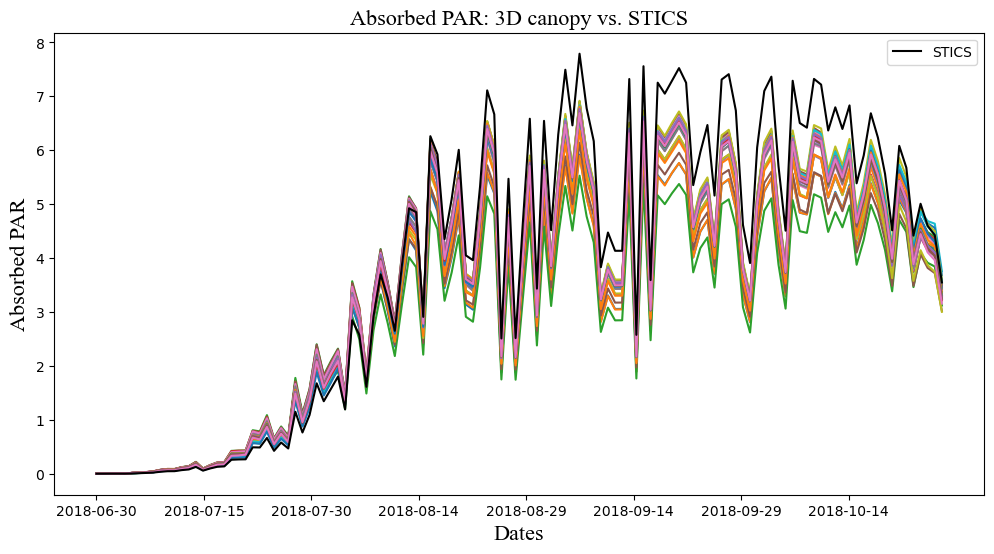

In [43]:
if nrj_per_plant[0][0] is not None:
    plot_PAR(dates, nrj_per_plant, par_incident, par_stics, sowing_density, stics_color="black")

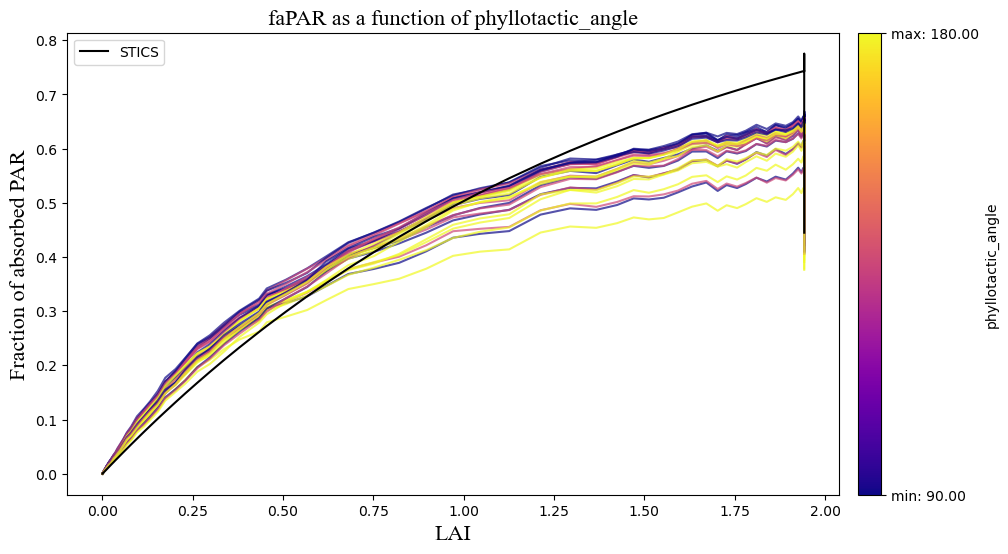

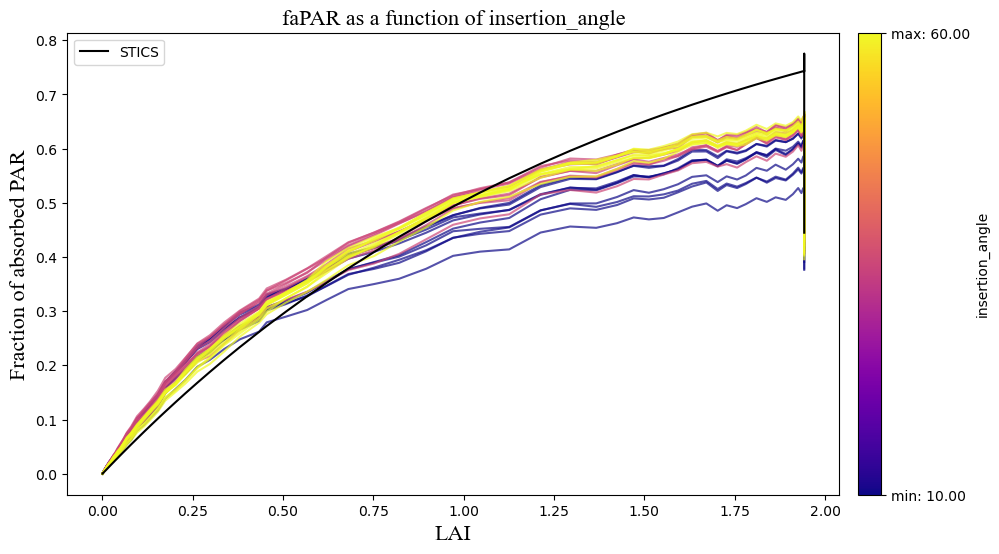

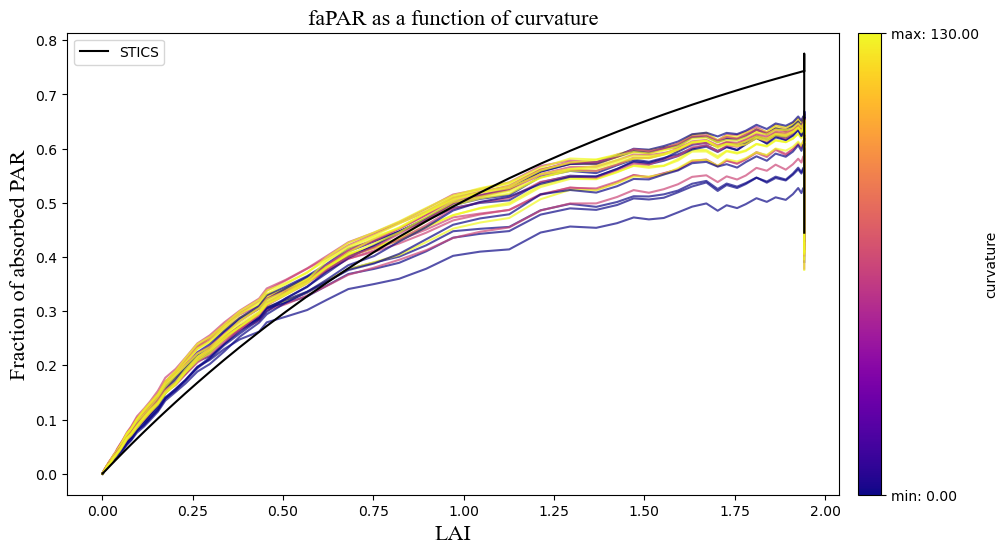

In [48]:
def plot_faPAR_lai_parameter(lai, nrj_per_plant, par_incident, par_stics, sowing_density, archi, parameter, parameter_name, archicrop_color, stics_color):
    fig, ax = plt.subplots(figsize=(12, 6))
    # for k,curve in nrj_per_plant.items():
    #     # ax.plot(dates, [nrj*sowing_density/par for nrj,par in zip(curve, par_incident)]) #, color=archicrop_color, alpha=0.4, label="ArchiCrop x Caribu")
    #     label = f"{parameter_name}={parameter[k]:.2f}" if parameter[k] == min(parameter) or parameter[k] == max(parameter) else None
    #     alpha = (parameter[k]-min(archi[parameter_name]))/(max(parameter)-min(archi[parameter_name]))
    #     ax.plot(dates, [nrj/par for nrj,par in zip(curve, par_incident)], color=archicrop_color, alpha=alpha, label=label) #, label=f"{parameter[k]}") #, color=archicrop_color, alpha=0.4, label="ArchiCrop x Caribu")

    # Normalize parameter values to [0, 1] for colormap
    param_values = np.array([parameter[k] for k in nrj_per_plant])
    norm = plt.Normalize(param_values.min(), param_values.max())
    cmap = plt.get_cmap('plasma')  # You can choose any matplotlib colormap

    for k, curve in nrj_per_plant.items():
        color = cmap(norm(parameter[k]))
        label = f"{parameter_name}={parameter[k]:.2f}" if parameter[k] == param_values.min() or parameter[k] == param_values.max() else None
        ax.plot(lai, [nrj/par for nrj, par in zip(curve, par_incident)], color=color, alpha=0.7) #, label=label)


    # ax.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
    # ax.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
    # ax.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
    ax.plot(lai, par_stics, color=stics_color, label="STICS")

    # Labels and legend
    # ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
    ax.set_xlabel("LAI", fontsize=16, fontname="Times New Roman") 
    ax.set_ylabel("Fraction of absorbed PAR", fontsize=16, fontname="Times New Roman")
    ax.set_title(f"faPAR as a function of {parameter_name}", fontsize=16, fontname="Times New Roman")

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(f"{parameter_name}")
    cbar.set_ticks([param_values.min(), param_values.max()])
    cbar.set_ticklabels([f"min: {param_values.min():.2f}", f"max: {param_values.max():.2f}"])


    ax.legend()

    # Save figure
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_faPAR_LAI_{parameter_name}.png")

    plt.show()

lai = [la*sowing_density/10000 for la in leaf_area_plant]
plot_faPAR_lai_parameter(lai, nrj_per_plant, par_incident, par_stics, sowing_density, archi, phyllotactic_angle, 'phyllotactic_angle', archicrop_color, stics_color='black')
plot_faPAR_lai_parameter(lai, nrj_per_plant, par_incident, par_stics, sowing_density, archi, insertion_angle, 'insertion_angle', archicrop_color, stics_color='black')
plot_faPAR_lai_parameter(lai, nrj_per_plant, par_incident, par_stics, sowing_density, archi, curvature, 'curvature', archicrop_color, stics_color='black')
# plot_faPAR_parameter(dates, nrj_per_plant, par_incident, par_stics, sowing_density, archi, scurv, 'scurv', archicrop_color, stics_color='black')

In [13]:
# see if sum eabs and esoil = 1
# see tests caribu (cf light vege manager in oa incubator)
# compute memory 

$$ raint(t)=0.95⋅parsurrgG⋅trg(t)⋅(1−exp(−extinP⋅(lai(t)+eai(t)))) $$

$$ parsurrgG = 0.48 $$

$$ extinP(maize) = 0.7 $$

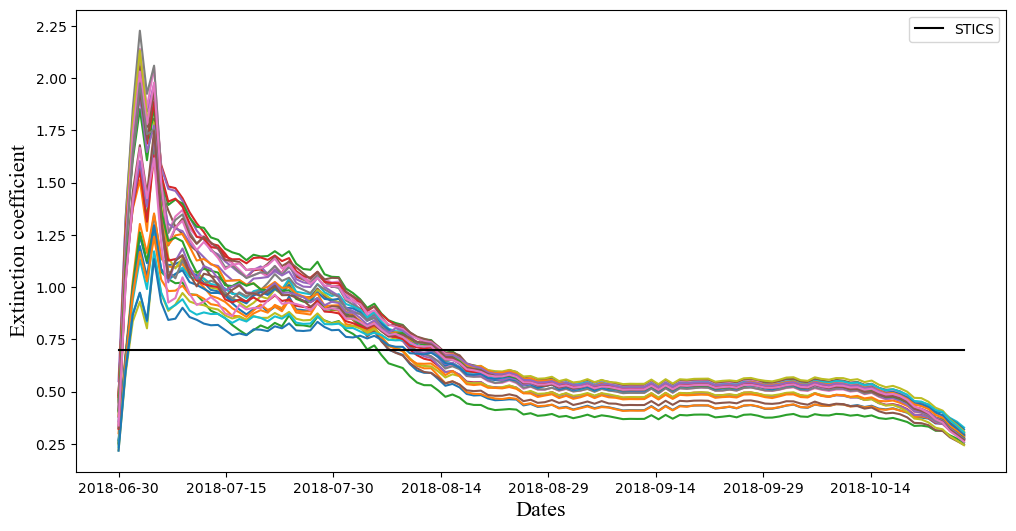

In [14]:
extinP_sorghum = 0.7

extinP_list = compute_extinction_coef(nrj_per_plant, par_incident, leaf_area_plant, sowing_density)
plot_extinction_coef(extinP_stics=extinP_sorghum, extinP_list=extinP_list, dates=dates)

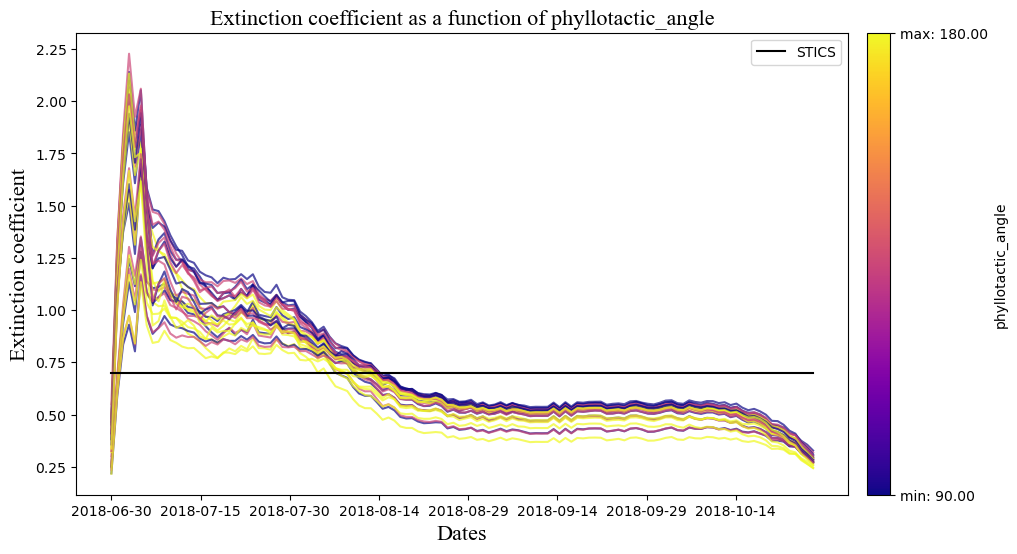

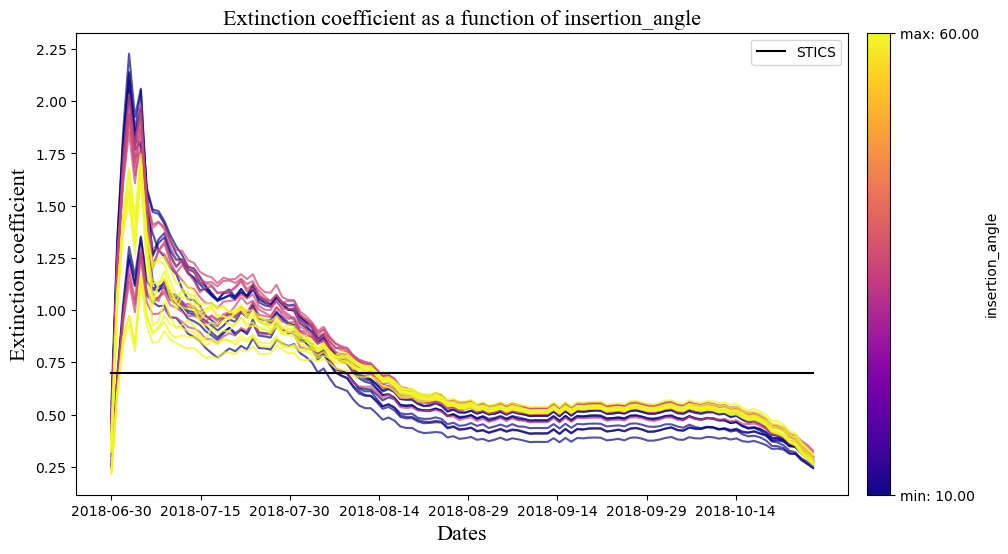

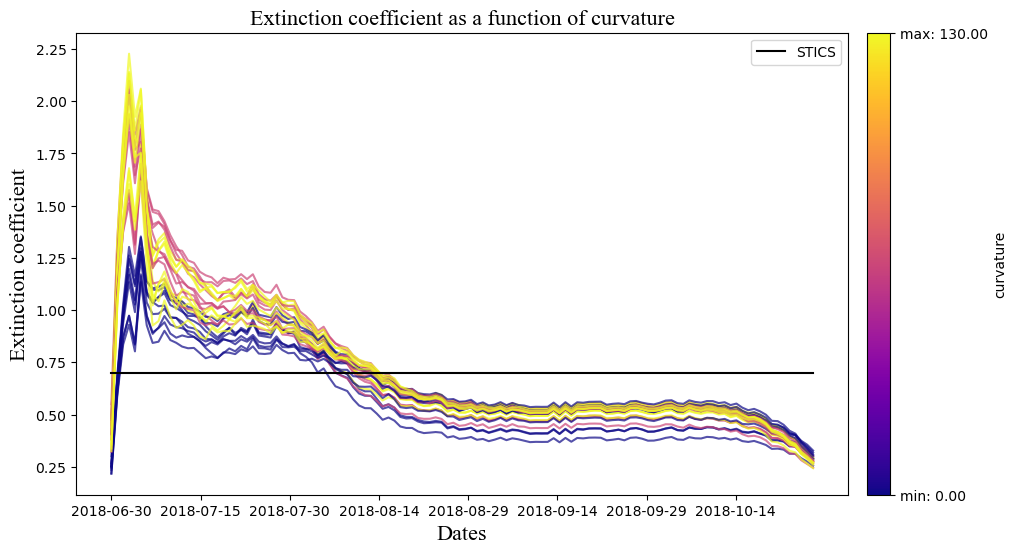

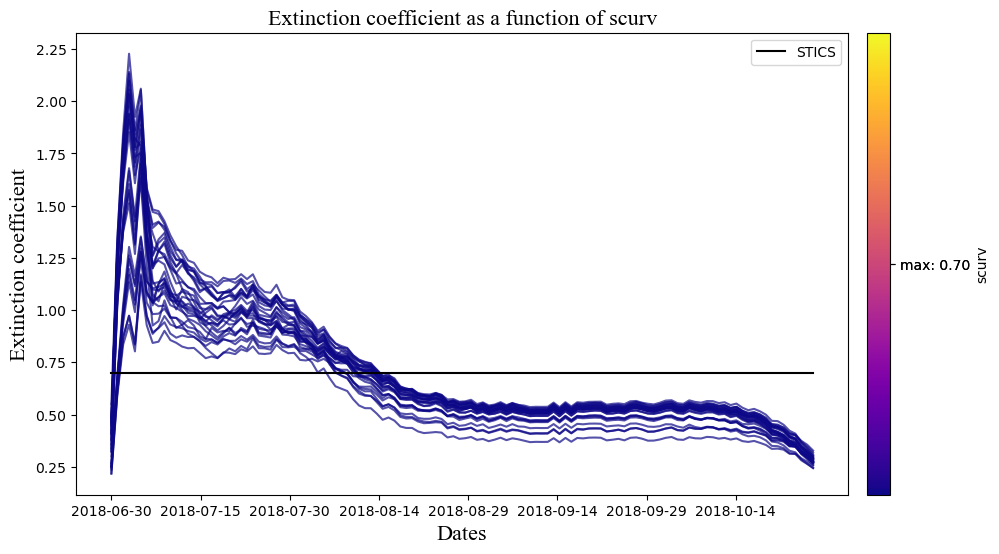

In [15]:
def plot_extinction_coef_parameter(extinP_stics, extinP_list, dates, archi, parameter, parameter_name, archicrop_color, stics_color):
    fig, ax = plt.subplots(figsize=(12, 6))
    # lai = [la*sowing_density/10000 for la in leaf_area_plant]
    # Normalize parameter values to [0, 1] for colormap
    param_values = np.array([parameter[k] for k in nrj_per_plant])
    norm = plt.Normalize(param_values.min(), param_values.max())
    cmap = plt.get_cmap('plasma')

    # Plot each curve with color from colormap
    for k,curve in enumerate(extinP_list):
        color = cmap(norm(parameter[k]))
        ax.plot(dates, curve, color=color, alpha=0.7)
        # label = f"{parameter_name}={parameter[k]:.2f}" if parameter[k] == min(parameter) or parameter[k] == max(parameter) else None
        # alpha = (parameter[k]-min(archi[parameter_name]))/(max(parameter)-min(archi[parameter_name]))
        # ax.plot(dates, curve, color=archicrop_color, alpha=alpha, label=label)
    ax.plot(dates, [extinP_stics]*len(dates), color=stics_color, label="STICS")
    ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
    ax.set_xlabel("Dates", fontsize=16, fontname="Times New Roman") 
    ax.set_ylabel("Extinction coefficient", fontsize=16, fontname="Times New Roman")
    ax.set_title(f"Extinction coefficient as a function of {parameter_name}", fontsize=16, fontname="Times New Roman")

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(f"{parameter_name}")
    cbar.set_ticks([param_values.min(), param_values.max()])
    cbar.set_ticklabels([f"min: {param_values.min():.2f}", f"max: {param_values.max():.2f}"])


    ax.legend()

    # Save figure
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_extin_coef_{parameter_name}.png")

    plt.show()


plot_extinction_coef_parameter(extinP_sorghum, extinP_list, dates, archi, phyllotactic_angle, 'phyllotactic_angle', archicrop_color, stics_color='black')
plot_extinction_coef_parameter(extinP_sorghum, extinP_list, dates, archi, insertion_angle, 'insertion_angle', archicrop_color, stics_color='black')
plot_extinction_coef_parameter(extinP_sorghum, extinP_list, dates, archi, curvature, 'curvature', archicrop_color, stics_color='black')
plot_extinction_coef_parameter(extinP_sorghum, extinP_list, dates, archi, scurv, 'scurv', archicrop_color, stics_color='black')

In [16]:
from openalea.plantgl.all import Color3, Material, Scene, Viewer

plant = ArchiCrop(daily_dynamics=daily_dynamics, **params)
plant.generate_potential_plant()

growing_plant = plant.grow_plant()
growing_plant_mtg = list(growing_plant.values())
mtgs[id] = growing_plant_mtg
Viewer.display(build_scene([-30])[0])

NameError: name 'ArchiCrop' is not defined

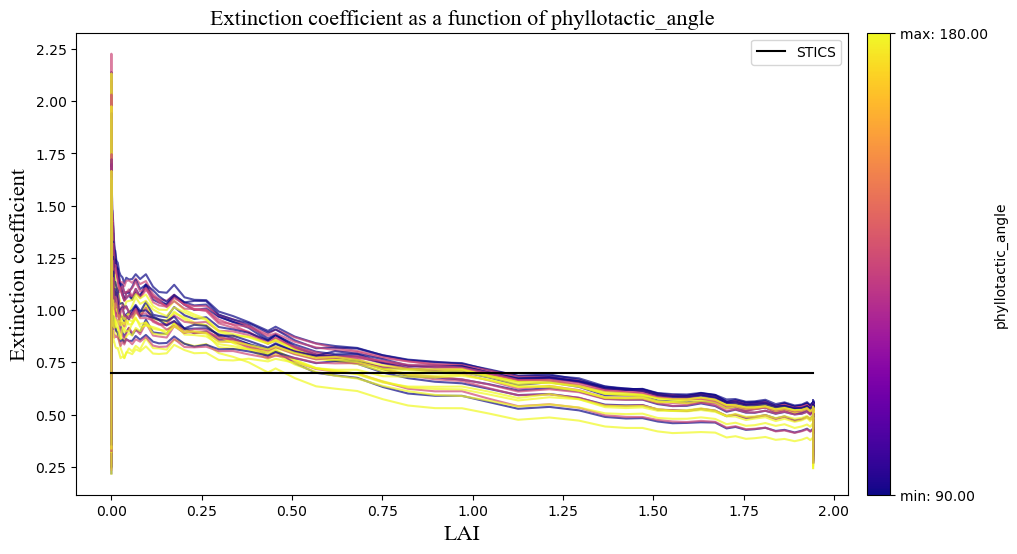

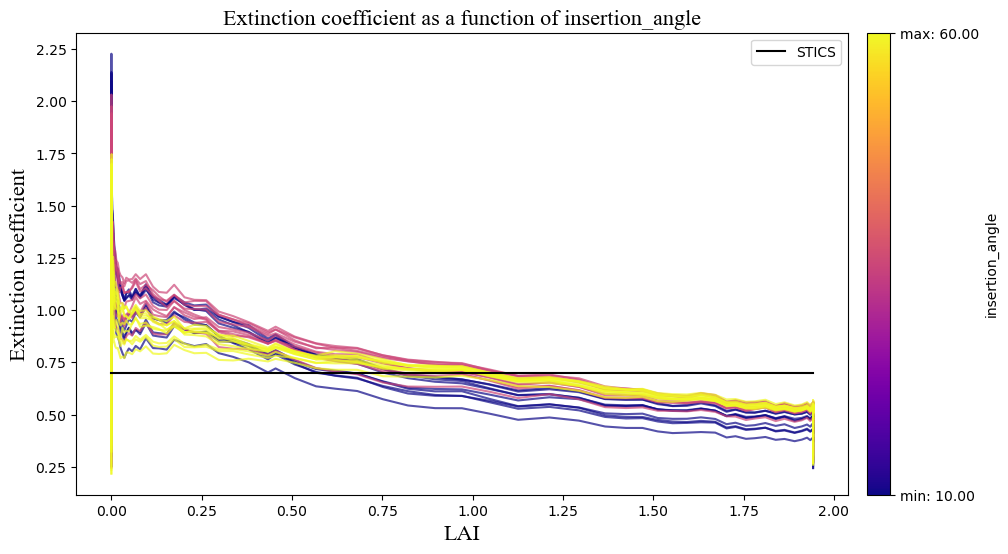

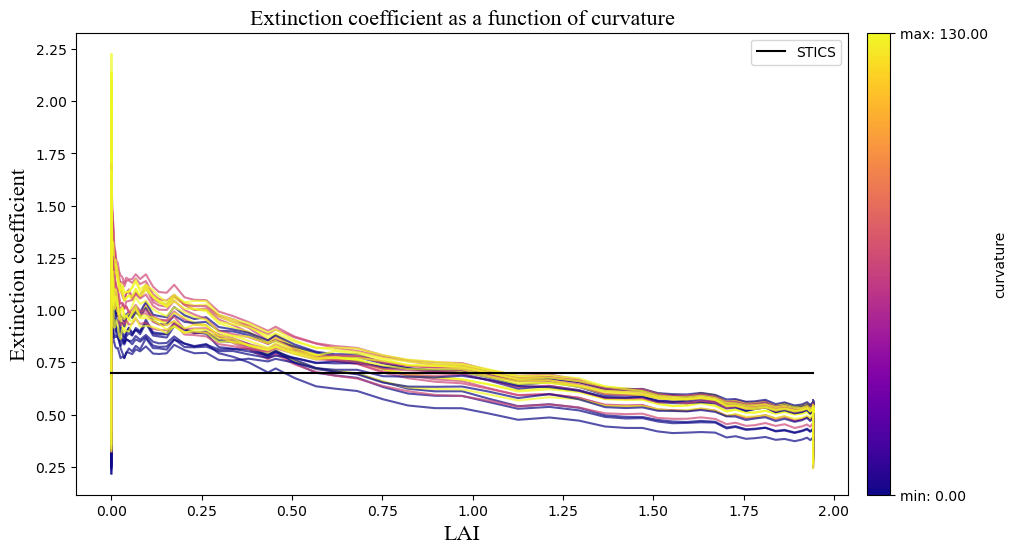

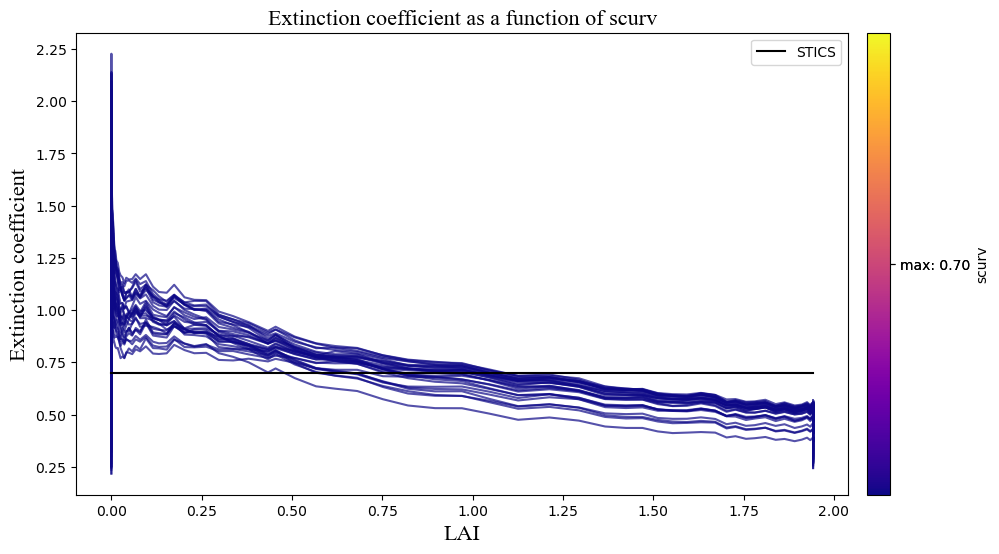

In [17]:
def plot_extinction_coef_lai_parameter(extinP_stics, extinP_list, lai, archi, parameter, parameter_name, archicrop_color, stics_color):
    fig, ax = plt.subplots(figsize=(12, 6))
    # lai = [la*sowing_density/10000 for la in leaf_area_plant]
    # Normalize parameter values to [0, 1] for colormap
    param_values = np.array([parameter[k] for k in nrj_per_plant])
    norm = plt.Normalize(param_values.min(), param_values.max())
    cmap = plt.get_cmap('plasma')

    # Plot each curve with color from colormap
    for k,curve in enumerate(extinP_list):
        color = cmap(norm(parameter[k]))
        ax.plot(lai, curve, color=color, alpha=0.7)
        # label = f"{parameter_name}={parameter[k]:.2f}" if parameter[k] == min(parameter) or parameter[k] == max(parameter) else None
        # alpha = (parameter[k]-min(archi[parameter_name]))/(max(parameter)-min(archi[parameter_name]))
        # ax.plot(dates, curve, color=archicrop_color, alpha=alpha, label=label)
    ax.plot(lai, [extinP_stics]*len(lai), color=stics_color, label="STICS")
    # ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
    ax.set_xlabel("LAI", fontsize=16, fontname="Times New Roman") 
    ax.set_ylabel("Extinction coefficient", fontsize=16, fontname="Times New Roman")
    ax.set_title(f"Extinction coefficient as a function of {parameter_name}", fontsize=16, fontname="Times New Roman")

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(f"{parameter_name}")
    cbar.set_ticks([param_values.min(), param_values.max()])
    cbar.set_ticklabels([f"min: {param_values.min():.2f}", f"max: {param_values.max():.2f}"])


    ax.legend()

    # Save figure
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_extin_coef_LAI_{parameter_name}.png")

    plt.show()

lai = [la*sowing_density/10000 for la in leaf_area_plant]
plot_extinction_coef_lai_parameter(extinP_sorghum, extinP_list, lai, archi, phyllotactic_angle, 'phyllotactic_angle', archicrop_color, stics_color='black')
plot_extinction_coef_lai_parameter(extinP_sorghum, extinP_list, lai, archi, insertion_angle, 'insertion_angle', archicrop_color, stics_color='black')
plot_extinction_coef_lai_parameter(extinP_sorghum, extinP_list, lai, archi, curvature, 'curvature', archicrop_color, stics_color='black')
plot_extinction_coef_lai_parameter(extinP_sorghum, extinP_list, lai, archi, scurv, 'scurv', archicrop_color, stics_color='black')

Average slope: -0.25358465517279555
Average intercept: 0.9686696575133106
0.02167998


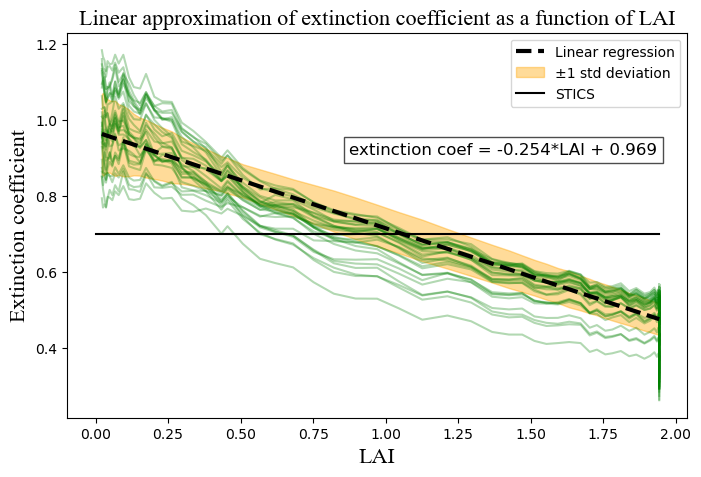

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

slopes, intercepts = [], []

start = 15
end = len(lai)-1
k = [coef[start:end] for coef in extinP_list]
lai_trunc = lai[start:end]

for y in k:  # loop over runs
    model = LinearRegression().fit(np.array(lai_trunc).reshape(-1,1), y)
    slopes.append(model.coef_[0])
    intercepts.append(model.intercept_)

# average slope & intercept
avg_slope = np.mean(slopes)
avg_intercept = np.mean(intercepts)

print("Average slope:", avg_slope)
print("Average intercept:", avg_intercept)

mean_series = np.array(k).mean(axis=0)

model = LinearRegression().fit(np.array(lai_trunc).reshape(-1,1), mean_series)
slope = model.coef_[0]
intercept = model.intercept_
equation = f"extinction coef = {slope:.3f}*LAI + {intercept:.3f}"
# print("Slope:", model.coef_[0])
# print("Intercept:", model.intercept_)

fit_line = model.predict(np.array(lai_trunc).reshape(-1,1))

# --- Compute residuals of each run vs fitted line ---
residuals = np.array(k) - fit_line  # shape (n_runs, n_timesteps)

# Standard deviation across runs at each time step
std_residuals = residuals.std(axis=0)

plt.figure(figsize=(8,5))
for y in k:  
    plt.plot(lai_trunc, y, alpha=0.3, color="green")
    
print(lai_trunc[0])
# plt.plot([lai_trunc[0],lai_trunc[0]], [0,1.2], alpha=0.3, color="green")
# plt.plot(lai_trunc, mean_series, color="black", linewidth=2, label="Mean series")
plt.plot(lai_trunc, fit_line, 
         color="black", linewidth=3, linestyle="--", label="Linear regression")

# Add error band (±1 std)
plt.fill_between(lai_trunc,
                 fit_line - std_residuals,
                 fit_line + std_residuals,
                 color="orange", alpha=0.4, label="±1 std deviation")

plt.plot(lai, [extinP_sorghum]*len(lai), color="black", label="STICS")

plt.text(0.45*max(lai_trunc), 0.9*max(mean_series), equation,
         fontsize=12, color="black", bbox=dict(facecolor="white", alpha=0.7))

plt.xlabel("LAI", fontsize=16, fontname="Times New Roman")
plt.ylabel("Extinction coefficient", fontsize=16, fontname="Times New Roman")
plt.legend()
plt.title("Linear approximation of extinction coefficient as a function of LAI", fontsize=16, fontname="Times New Roman")

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_extin_coef_LAI_linear_regression.png")


plt.show()

0.0151


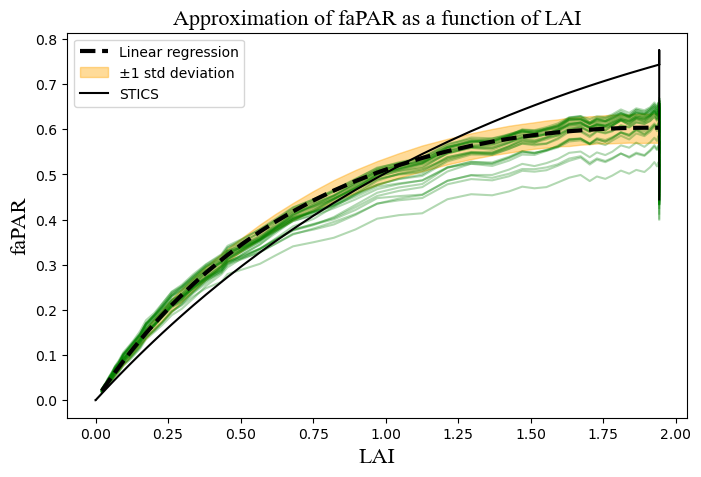

In [ ]:
faPAR_trunc = [nrj[start:end] for nrj in nrj_per_plant.values()]
new_faPAR = 1 - np.exp(-fit_line * np.array(lai_trunc))
print(par_stics[start])

plt.figure(figsize=(8,5))
for y in faPAR_trunc:  
    plt.plot(lai_trunc, [nrj/par for nrj, par in zip(y, par_incident[start:end])], alpha=0.3, color="green")
    
# plt.plot([lai_trunc[0],lai_trunc[0]], [0,1.2], alpha=0.3, color="green")
# plt.plot(lai_trunc, mean_series, color="black", linewidth=2, label="Mean series")
plt.plot(lai_trunc, new_faPAR, 
         color="black", linewidth=3, linestyle="--", label="Regression of faPAR")

# Add error band (±1 std)
plt.fill_between(lai_trunc,
                 1 - np.exp(-(fit_line - std_residuals) * np.array(lai_trunc)),
                 1 - np.exp(-(fit_line + std_residuals) * np.array(lai_trunc)),
                 color="orange", alpha=0.4, label="±1 std deviation")

plt.plot(lai, par_stics, color="black", label="STICS")

# plt.text(0.45*max(lai_trunc), 0.9*max(mean_series), equation,
#          fontsize=12, color="black", bbox=dict(facecolor="white", alpha=0.7))

plt.xlabel("LAI", fontsize=16, fontname="Times New Roman")
plt.ylabel("faPAR", fontsize=16, fontname="Times New Roman")
plt.legend()
plt.title("Approximation of faPAR as a function of LAI", fontsize=16, fontname="Times New Roman")

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_faPAR_LAI_regression.png")


plt.show()

BIC = -649.64


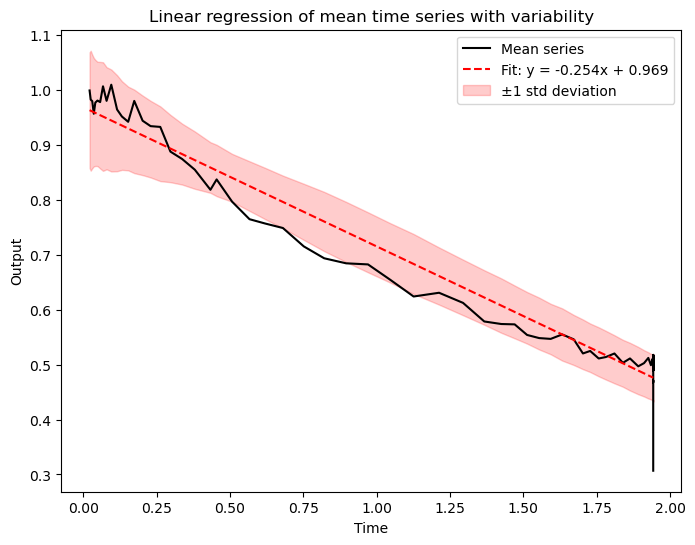

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

mean_series = np.array(k).mean(axis=0)       # average time series

# --- Fit linear regression to mean series ---
model = LinearRegression().fit(np.array(lai_trunc).reshape(-1,1), mean_series)
slope = model.coef_[0]
intercept = model.intercept_
fit_line = model.predict(np.array(lai_trunc).reshape(-1,1))

# --- Compute residuals of each run vs fitted line ---
residuals = k - fit_line  # shape (n_runs, n_timesteps)

# Standard deviation across runs at each time step
std_residuals = residuals.std(axis=0)

# Compute residual sum of squares (RSS)
residuals = mean_series - fit_line
rss = np.sum(residuals**2)

# Number of data points
n = len(mean_series)   # using mean series only
k = 2                  # slope + intercept

# BIC
bic = n * np.log(rss/n) + k * np.log(n)
print(f"BIC = {bic:.2f}")

# --- Plot ---
plt.figure(figsize=(8,6))

# Plot mean series
plt.plot(lai_trunc, mean_series, label="Mean series", color="black")

# Plot linear fit
plt.plot(lai_trunc, fit_line, color="red", linestyle="--", label=f"Fit: y = {slope:.3f}x + {intercept:.3f}")

# Add error band (±1 std)
plt.fill_between(lai_trunc,
                 fit_line - std_residuals,
                 fit_line + std_residuals,
                 color="red", alpha=0.2, label="±1 std deviation")

plt.xlabel("Time")
plt.ylabel("Output")
plt.title("Linear regression of mean time series with variability")
plt.legend()
plt.show()


In [ ]:
### Plot leaf lengths
for l in range(len(mtgs[1].properties()["leaf_lengths"].values())):  # noqa: E741
    # print(list(growing_plant[time[1]].properties()["leaf_lengths"].values()))
    # print(list(growing_plant[time[-1]].properties()["leaf_lengths"].values()))
    plt.plot(dates[1:], 
             [list(growing_plant[t].properties()["leaf_lengths"].values())[l][-1] - list(growing_plant[t].properties()["senescent_lengths"].values())[l][-1] for t in time[1:]], 
             color="green")

plt.xlabel("Thermal time")
plt.ylabel("Leaf length")
# plt.legend(loc="upper left")

plt.show()

Explained variance ratio: [0.67981921 0.25726889 0.04272022 0.00814673 0.00565363]


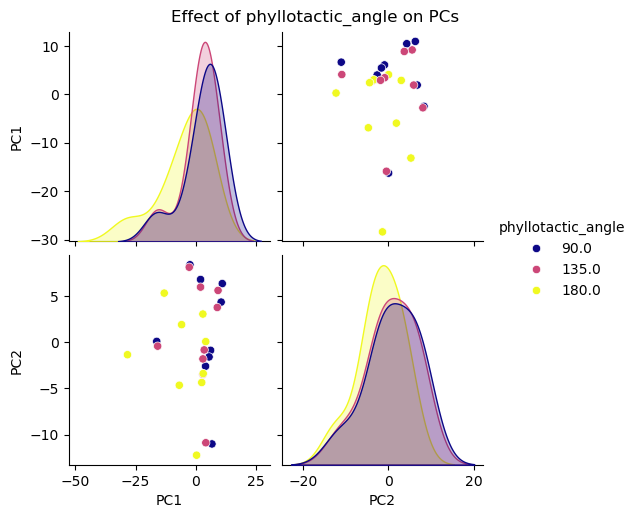

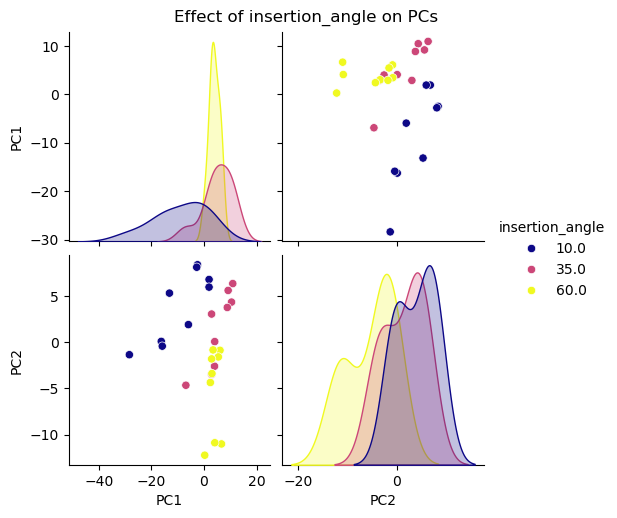

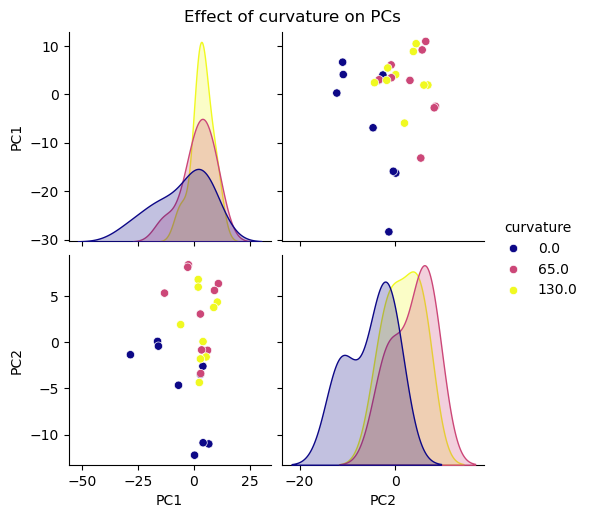

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Example: say you did 50 model runs, each with 100 timesteps
n_runs = 27
n_timesteps = len(dates)

# phyllotactic_angle = ds.phyllotactic_angle.values
# insertion_angle = ds.insertion_angle.values
# curvature = ds.curvature.values

# nrj_per_plant = dict(zip(ds.id.values, ds.nrj_per_plant.values))
nrj_per_plant = ds.nrj_per_plant.values

# --- PCA on time series ---
scaler = StandardScaler()
outputs_scaled = scaler.fit_transform(nrj_per_plant)

pca = PCA(n_components=5)  # keep first 5 PCs
pcs = pca.fit_transform(outputs_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# --- Visualize first two PCs vs parameters ---
df = pd.DataFrame({
    "PC1": pcs[:,0],
    "PC2": pcs[:,1],
    "phyllotactic_angle": phyllotactic_angle,
    "insertion_angle": insertion_angle,
    "curvature": curvature
})

sns.pairplot(df, vars=["PC1", "PC2"], hue="phyllotactic_angle", palette="plasma")
plt.suptitle("Effect of phyllotactic_angle on PCs", y=1.02)
plt.show()

sns.pairplot(df, vars=["PC1", "PC2"], hue="insertion_angle", palette="plasma")
plt.suptitle("Effect of insertion_angle on PCs", y=1.02)
plt.show()

sns.pairplot(df, vars=["PC1", "PC2"], hue="curvature", palette="plasma")
plt.suptitle("Effect of curvature on PCs", y=1.02)
plt.show()

# sns.scatterplot(x="insertion_angle", y="PC1", data=df)
# plt.title("Effect of insertion_angle on PC1")
# plt.show()

# sns.scatterplot(x="curvature", y="PC2", data=df)
# plt.title("Effect of curvature on PC2")
# plt.show()


     Effect of phyllotactic_angle  Effect of insertion_angle  \
PC1                        -0.085                      0.256   
PC2                        -0.032                     -0.182   

     Effect of curvature     R²  
PC1                0.070  0.621  
PC2                0.053  0.742  


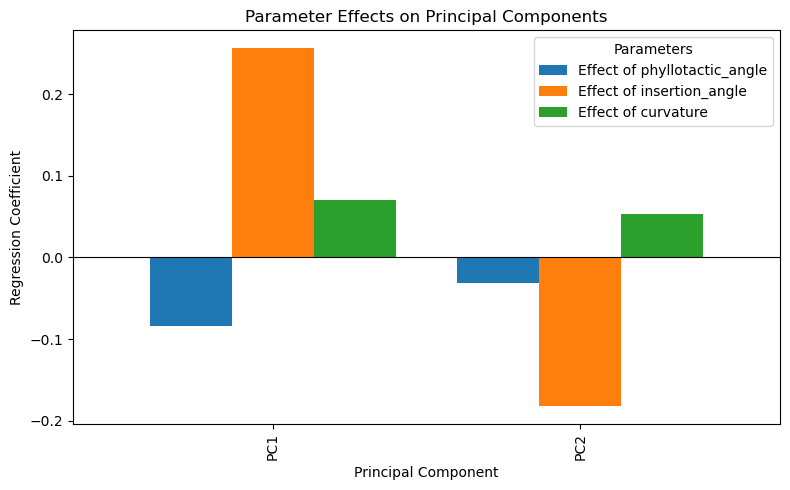

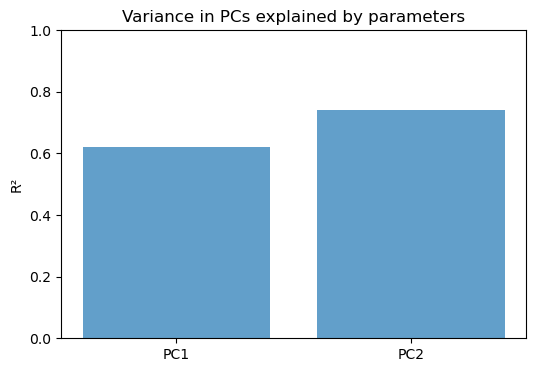

In [20]:
from sklearn.linear_model import LinearRegression

# --- Sensitivity analysis: regress PCs on parameters ---
X = np.vstack([phyllotactic_angle, insertion_angle, curvature]).T  # inputs matrix
sensitivities = {}
rows = []

for i in range(2):  # check first 3 PCs
    y = pcs[:, i]
    model = LinearRegression().fit(X, y)
    row = list(model.coef_) + [model.score(X, y)]  # 3 coefs + R²
    rows.append(row)

df_sens = pd.DataFrame(
    rows,
    columns=["Effect of phyllotactic_angle", "Effect of insertion_angle", "Effect of curvature", "R²"],
    index=[f"PC{i+1}" for i in range(2)]
)

print(df_sens.round(3))



# --- Plot parameter effects per PC ---
ax = df_sens.drop(columns="R²").plot(
    kind="bar", figsize=(8,5), width=0.8
)

plt.title("Parameter Effects on Principal Components")
plt.ylabel("Regression Coefficient")
plt.xlabel("Principal Component")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend(title="Parameters")
plt.tight_layout()
plt.show()

# --- Plot R² separately (how well PCs are explained by parameters) ---
plt.figure(figsize=(6,4))
plt.bar(df_sens.index, df_sens["R²"], alpha=0.7)
plt.ylabel("R²")
plt.title("Variance in PCs explained by parameters")
plt.ylim(0, 1)
plt.show()


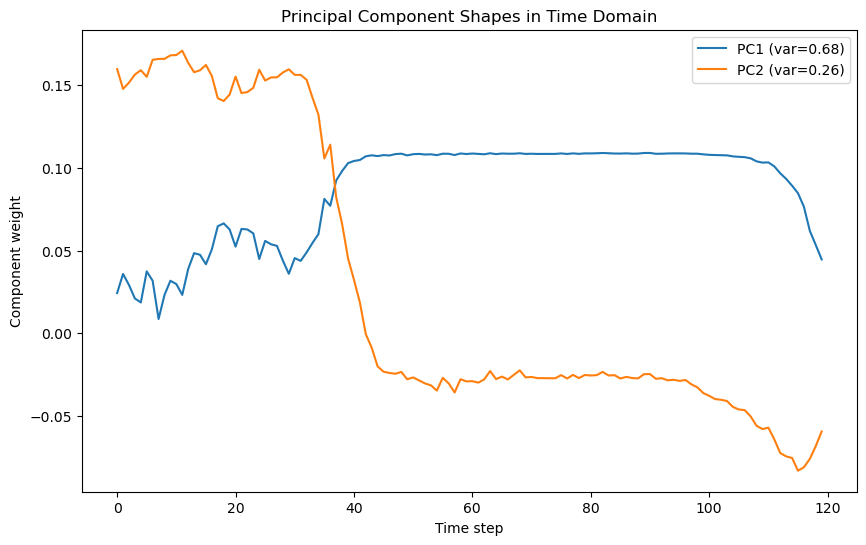

In [ ]:
# --- Plot the shape of the first few PCs ---
plt.figure(figsize=(10,6))

for i in range(2):  # first 3 PCs
    plt.plot(
        np.arange(n_timesteps),
        pca.components_[i],
        label=f"PC{i+1} (var={pca.explained_variance_ratio_[i]:.2f})"
    )

plt.xlabel("Time step")
plt.ylabel("Component weight")
plt.title("Principal Component Shapes in Time Domain")
plt.legend()
plt.show()

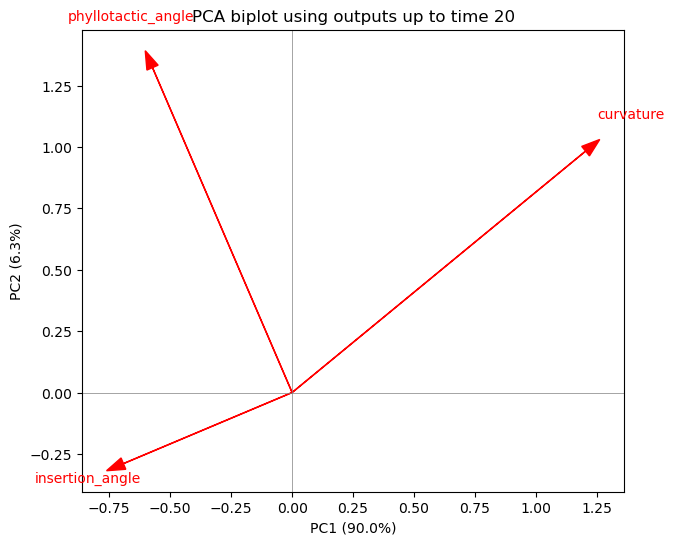

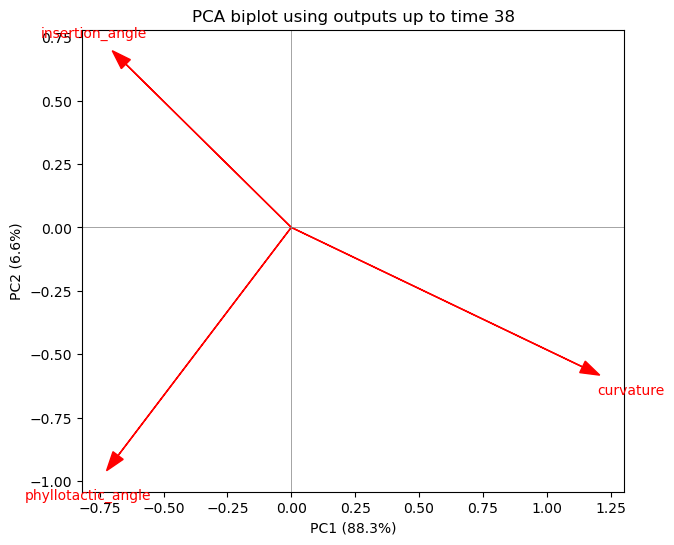

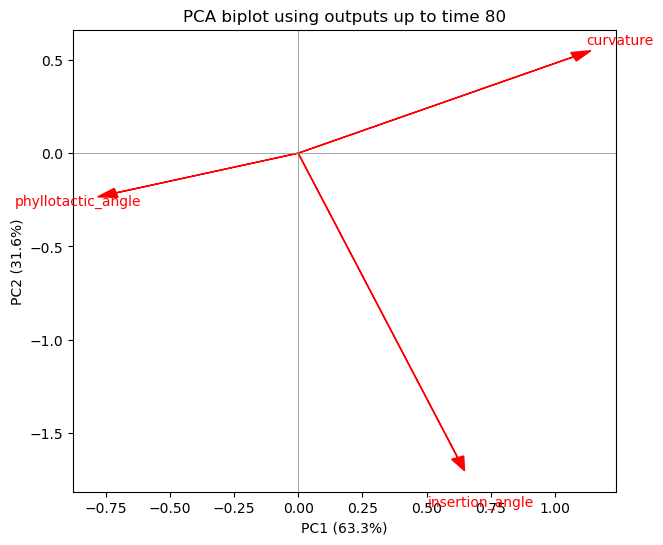

In [ ]:
import matplotlib.pyplot as plt

# --- choose time window up to t ---
times = [20, 38, 80]

for t in times:
    outputs_t = nrj_per_plant[:, :t]  # shape = (n_runs, t)

    # --- PCA on truncated outputs ---
    scaler = StandardScaler()
    outputs_t_scaled = scaler.fit_transform(outputs_t)
    pca_t = PCA(n_components=2)
    scores_t = pca_t.fit_transform(outputs_t_scaled)

    # --- correlate parameters with PC scores ---
    params = np.vstack([phyllotactic_angle, insertion_angle, curvature]).T
    param_names = ["phyllotactic_angle", "insertion_angle", "curvature"]

    loadings = np.zeros((3, 2))
    for i in range(3):
        for j in range(2):
            loadings[i, j] = np.corrcoef(params[:, i], scores_t[:, j])[0, 1]

    # --- plot biplot ---
    plt.figure(figsize=(7,6))
    # plt.scatter(scores_t[:,0], scores_t[:,1], alpha=0.7)

    arrow_scale = 2.0
    for i, name in enumerate(param_names):
        plt.arrow(0, 0,
                loadings[i,0]*arrow_scale,
                loadings[i,1]*arrow_scale,
                color='red', head_width=0.05, length_includes_head=True)
        plt.text(loadings[i,0]*arrow_scale*1.1,
                loadings[i,1]*arrow_scale*1.1,
                name, color='red', ha='center', va='center')

    plt.xlabel(f"PC1 ({pca_t.explained_variance_ratio_[0]:.1%})")
    plt.ylabel(f"PC2 ({pca_t.explained_variance_ratio_[1]:.1%})")
    plt.title(f"PCA biplot using outputs up to time {t}")
    plt.axhline(0, color="gray", linewidth=0.5)
    plt.axvline(0, color="gray", linewidth=0.5)
    plt.show()



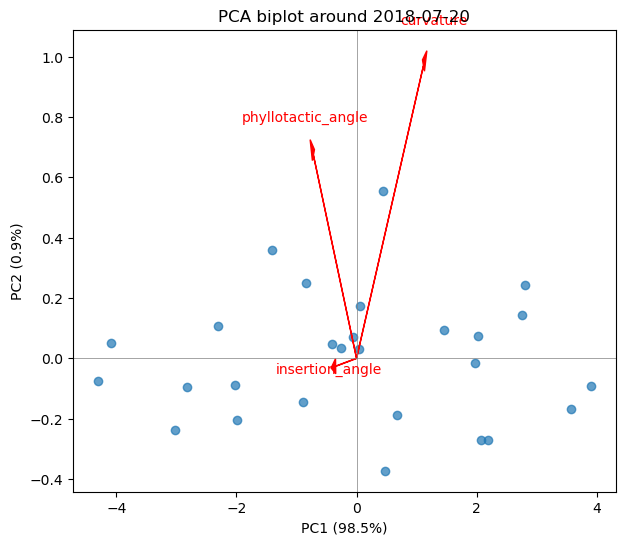

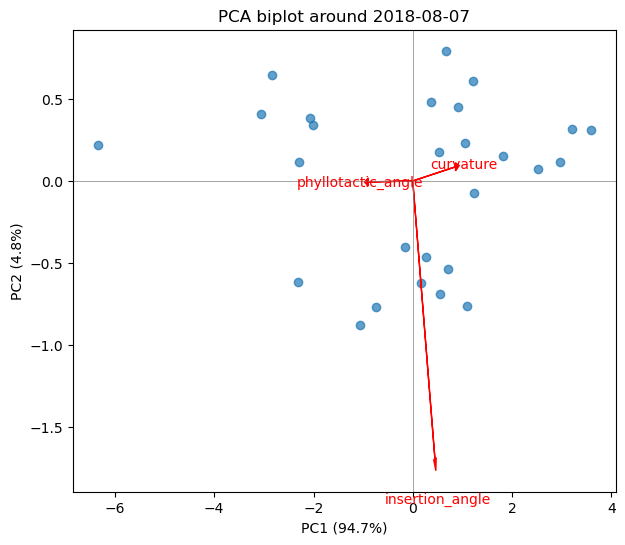

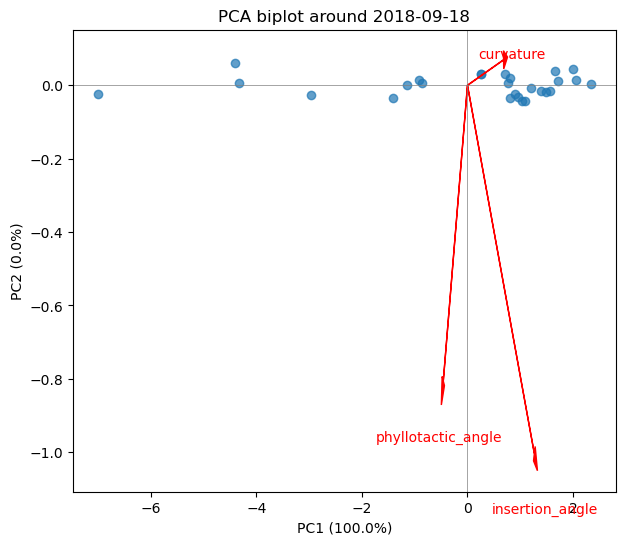

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Parameters ---
window_size = 5  # number of timesteps in the window
times = [20, 38, 80]  # center time
half_win = window_size // 2

for t in times:
    # --- Extract local window around t ---
    outputs_window = nrj_per_plant[:, t-half_win : t+half_win+1]  # shape = (n_runs, window_size)

    # --- Standardize windowed outputs ---
    scaler = StandardScaler()
    outputs_scaled = scaler.fit_transform(outputs_window)

    # --- PCA ---
    pca = PCA(n_components=2)
    scores = pca.fit_transform(outputs_scaled)

    # --- Correlation of parameters with PCs (for arrows) ---
    params = np.vstack([phyllotactic_angle, insertion_angle, curvature]).T
    param_names = ["phyllotactic_angle", "insertion_angle", "curvature"]

    loadings = np.zeros((3, 2))
    for i in range(3):
        for j in range(2):
            loadings[i, j] = np.corrcoef(params[:, i], scores[:, j])[0, 1]

    # --- Biplot ---
    plt.figure(figsize=(7,6))
    plt.scatter(scores[:,0], scores[:,1], alpha=0.7)

    arrow_scale = 2.0
    for i, name in enumerate(param_names):
        plt.arrow(0, 0,
                loadings[i,0]*arrow_scale,
                loadings[i,1]*arrow_scale,
                color='red', head_width=0.05, length_includes_head=True)
        plt.text(loadings[i,0]*arrow_scale*1.1,
                loadings[i,1]*arrow_scale*1.1,
                name, color='red', ha='center', va='center')

    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
    plt.title(f"PCA biplot around {dates[t]}")
    plt.axhline(0, color="gray", linewidth=0.5)
    plt.axvline(0, color="gray", linewidth=0.5)
    plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Create interaction terms (p1*p2, p1*p3, p2*p3, p1*p2*p3)
X = np.vstack([phyllotactic_angle, insertion_angle, curvature]).T
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = poly.fit_transform(X)

# Regress first PC (or any PC) on parameters + interactions
y = scores[:,0]  # e.g., PC1 from the local window
model = LinearRegression().fit(X_interact, y)

# Inspect coefficients
coef_names = poly.get_feature_names_out(["phyllotactic_angle", "insertion_angle", "curvature"])
df_coef = pd.DataFrame({"Term": coef_names, "Coefficient": model.coef_})
print(df_coef)


                                 Term  Coefficient
0                  phyllotactic_angle    -0.031367
1                     insertion_angle     0.092460
2                           curvature     0.032431
3  phyllotactic_angle insertion_angle     0.000272
4        phyllotactic_angle curvature     0.000104
5           insertion_angle curvature    -0.000871


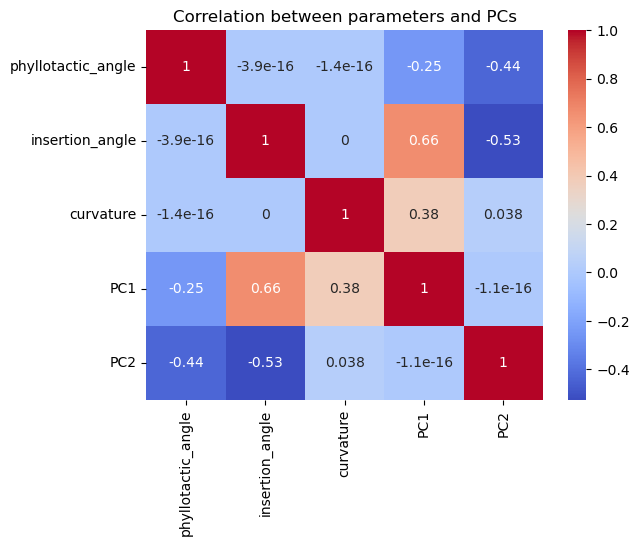

In [ ]:
import seaborn as sns

df = pd.DataFrame({
    "phyllotactic_angle": phyllotactic_angle,
    "insertion_angle": insertion_angle,
    "curvature": curvature,
    "PC1": scores[:,0],
    "PC2": scores[:,1]
})

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between parameters and PCs")
plt.show()

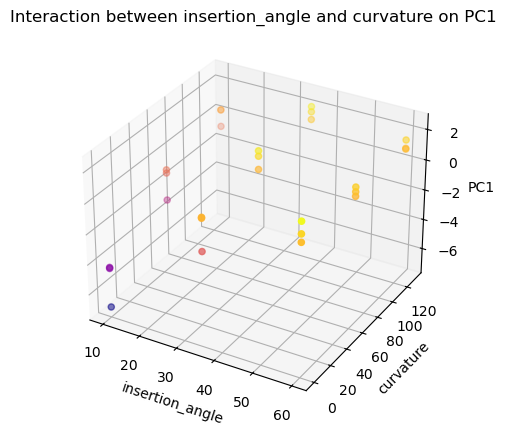

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(insertion_angle, curvature, scores[:,0], c=scores[:,0], cmap='plasma')
ax.set_xlabel("insertion_angle")
ax.set_ylabel("curvature")
ax.set_zlabel("PC1")
plt.title("Interaction between insertion_angle and curvature on PC1")
plt.show()

In [ ]:
from SALib.analyze import sobol

problem = {
    'num_vars': 4,
    'names': ['insertion_angle', 'curvature', 'phyllotactic_angle'],
    'bounds': []
}
for name in problem['names']:
    problem['bounds'].append([min(archi[name]), max(archi[name])])

N = len(extinP_list)
T = len(extinP_list[0])
d = problem['num_vars']

S_i = np.zeros((d, T))

for t in range(T):
    Y_t = np.array([extinP_list[i][t] for i in range(len(extinP_list))])
    Si = sobol.analyze(problem, Y_t, print_to_console=False) # ca marche pas parce que c'est un sampling LHS et pas Saltelli
    S_i[:, t] = Si['S1']

Si.plot()
# # S_i[i, t] = indice de Sobol du paramètre i à l'instant t
# for i,name in enumerate(problem['names']):
#     plt.plot(dates, S_i[i, :], label=name)
# plt.xlabel('Dates')
# plt.ylabel('Sobol indices')
# plt.legend()
# plt.show()

c:\Users\cheriere\miniconda3\envs\ArchiCrop\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

In [ ]:
"""
# vertical light interception
cs, ei, df = illuminate(scene, scene_unit='cm')
cs.plot(ei)


# diffuse light interception
sources = skys.sky_sources()
cs, ei, df = illuminate(scene, light=sources, scene_unit='cm')
cs.plot(ei)

# get score per plant
def score(res):
    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),
                              'area': res.area.sum()})
df['nump']=nump
df.groupby('nump').apply(score)
"""

"\n# vertical light interception\ncs, ei, df = illuminate(scene, scene_unit='cm')\ncs.plot(ei)\n\n\n# diffuse light interception\nsources = skys.sky_sources()\ncs, ei, df = illuminate(scene, light=sources, scene_unit='cm')\ncs.plot(ei)\n\n# get score per plant\ndef score(res):\n    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),\n                              'area': res.area.sum()})\ndf['nump']=nump\ndf.groupby('nump').apply(score)\n"